In [1]:
import warnings
import os
%load_ext autoreload
%autoreload 2
os.chdir('..')

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1" # Specifying the device as 'cuda' will have the same effect as cuda:1, change this number to select a different GPU

os.getcwd()

'/users/ug22/deevyanshumalu/CS-726-Assignments/Assignment-2'

In [2]:
from dataset import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import utils
import torch

# Visualization

## Dataset Info

albatross: size: 32561, dim : 64
moons: size: 8000, dim : 2, number of classes: [0 1]
circles: size: 8000, dim : 2, number of classes: [0 1]
manycircles: size: 8000, dim : 2, number of classes: [0 1 2 3 4 5 6 7]
blobs: size: 8000, dim : 2, number of classes: [0 1]
helix: size: 10000, dim : 3, number of classes: [0 1]


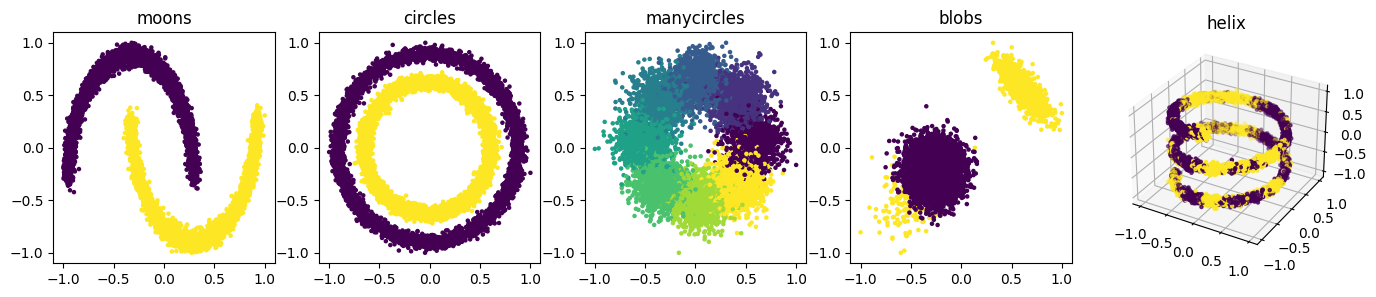

In [ ]:
dataset_list = ['albatross', 'moons', 'circles', 'manycircles', 'blobs', 'helix'] # available datasets

fig = plt.figure(figsize=(20, 3))
for i,dataset_name in enumerate(dataset_list):
    data_X, data_y = load_dataset(dataset_name)
    if data_y is not None:
        print(f"{dataset_name}: size: {data_X.shape[0]}, dim : {data_X.shape[1]}, number of classes: {len(np.unique(data_y))}")
    else:
        print(f"{dataset_name}: size: {data_X.shape[0]}, dim : {data_X.shape[1]}")

    if data_X.shape[1] == 2:
        ax = fig.add_subplot(1, len(dataset_list),i+1)
        ax.scatter(data_X[:, 0], data_X[:, 1], c = data_y, cmap='viridis', s = 5)
        ax.set_title(f"{dataset_name}")
    elif data_X.shape[1] == 3:
        ax = fig.add_subplot(1, len(dataset_list),i+1,projection='3d')
        ax.scatter(data_X[:, 0], data_X[:, 1], data_X[:, 2], c = data_y, cmap='viridis', s = 5)
        ax.set_title(f"{dataset_name}")

plt.show()

## Visualizing Classification Boundaries

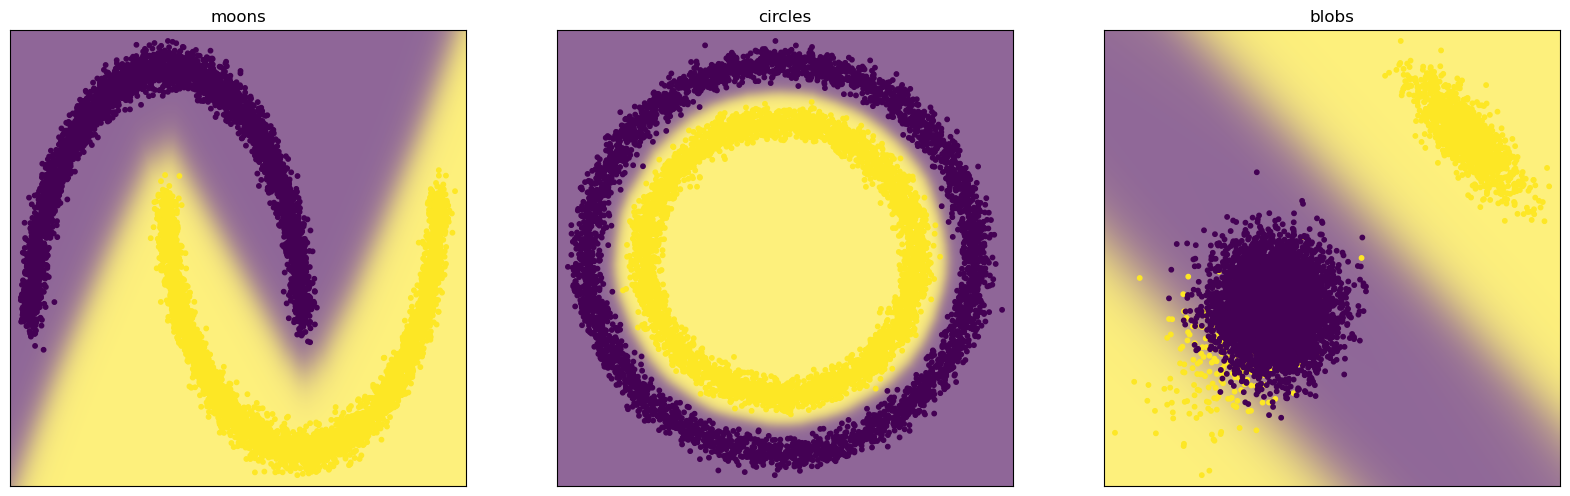

In [8]:
from sklearn.neural_network import MLPClassifier

dataset_list = ['moons', 'circles', 'blobs'] # 2d datasets with 2 classes

for contour_ in [False, True]:
    fig = plt.figure(figsize=(20, 6.5))
    for i,dataset_name in enumerate(dataset_list):
        data_X, data_y = load_dataset(dataset_name)
        clf = MLPClassifier().fit(data_X, data_y) 

        ax = fig.add_subplot(1, len(dataset_list),i+1)
        ax.scatter(data_X[:, 0], data_X[:, 1], c = data_y, cmap='viridis', s = 10)
        utils.viz_clf(ax, clf, contour=contour_) 
        # training a classifier from sklearn, can be replaced with any torch classifier as long predict proba method is implemented
        # sklearn will be slower than torch
        ax.set_title(f"{dataset_name}")

    plt.show()

## Visualizing Diffusion Process
We will visualize the "reverse" diffusion process. Here we are just constructing a dataset from forward process and animating it in reverse. This is how the samples should  look like for a well trained model.

In [29]:
from ddpm import NoiseScheduler # other modules can also be imported; model definition, training, sampling etc. 
from IPython.display import HTML


noise_scheduler = NoiseScheduler(100,type='linear', beta_start=0.0001, beta_end=0.02) 

dataset_name = 'moons'
data_X, data_y = load_dataset(dataset_name)

forward_diff_dataset_unrolled = [data_X]
for i in range(len(noise_scheduler)):
    # [redacted]
    # [redacted]
    forward_diff_dataset_unrolled.append# [redacted]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(6, 6))
ani = utils.animateScatter2d(fig, ax, list(reversed(forward_diff_dataset_unrolled)), dataset_name)
plt.close()  # Prevents duplicate display
display(HTML(ani.to_html5_video()))

# sometimes video is not rendered in jupyter notebook, so we just save it.
# ani.save('diffusion-{dataset_name}.mp4', writer='ffmpeg')
# ani.save(f'diffusion-{dataset_name}.gif', writer='pillow') # !pip install pillow

## Evaluation

In [ ]:
data_X, data_y = load_dataset('moons')
train_X, train_y, test_X, test_y = utils.split_data(data_X, data_y, 0.8)

samples = torch.randn(2000, 2) # samples from standard normal distribution -- ood wrt to moons

print(f"NLL of samples w.r.t train split: {utils.get_nll(train_X, samples):.3f}")
print(f"NLL of samples w.r.t test  split {utils.get_nll(test_X, samples):.3f}")
print(f"NLL of Test Data w.r.t train split: {utils.get_nll(train_X, test_X):.3f}") # should be lower than the above two
# get_nll take a temperature parameter. This should be included in the report.


NLL of samples w.r.t train split: 1.558
NLL of samples w.r.t test  split 1.558
NLL of Test Data w.r.t train split: 0.946


expected value of EMD for OOD samples

In [10]:
# EMD can be very slow. So we will use subsampled data. Ideally we should calculate EMD over many subsamplings and average it
# include subsample_size in your report and number of times you subsampled to average

subsample_size = 600
train_emd_list = []
test_emd_list = []
for i in range(5):
    subsample_test_X = utils.sample(test_X, size = subsample_size)
    subsample_train_X = utils.sample(train_X, size = subsample_size)
    subsample_samples = utils.sample(samples, size = subsample_size)
    test_emd =  utils.get_emd(subsample_test_X.numpy(), subsample_samples.numpy())
    train_emd = utils.get_emd(subsample_train_X.numpy(), subsample_samples.numpy())
    print(f'{i} EMD w.r.t test split : {test_emd: .3f}')
    print(f'{i} EMD w.r.t train split: {train_emd: .3f}')
    train_emd_list.append(train_emd)
    test_emd_list.append(test_emd)

print(f" ---------------------------------")
print(f"Average EMD w.r.t test split : {np.mean(test_emd_list):.3f} ± {np.std(test_emd_list):.3f}")
print(f"Average EMD w.r.t train split: {np.mean(train_emd_list):.3f} ± {np.std(train_emd_list):.3f}")

0 EMD w.r.t test split :  338.066
0 EMD w.r.t train split:  334.091
1 EMD w.r.t test split :  355.568
1 EMD w.r.t train split:  345.360
2 EMD w.r.t test split :  356.624
2 EMD w.r.t train split:  343.705
3 EMD w.r.t test split :  339.457
3 EMD w.r.t train split:  341.016
4 EMD w.r.t test split :  347.867
4 EMD w.r.t train split:  350.347
 ---------------------------------
Average EMD w.r.t test split : 347.516 ± 7.774
Average EMD w.r.t train split: 342.904 ± 5.354


Let's see the expected value of EMD if sampling process was perfect

In [11]:
samples = test_X # perfect samples!
subsample_size = 600
train_emd_list = []
test_emd_list = []
for i in range(5):
    subsample_test_X = utils.sample(test_X, size = subsample_size)
    subsample_train_X = utils.sample(train_X, size = subsample_size)
    subsample_samples = utils.sample(samples, size = subsample_size)
    test_emd =  utils.get_emd(subsample_test_X.numpy(), subsample_samples.numpy())
    train_emd = utils.get_emd(subsample_train_X.numpy(), subsample_samples.numpy())
    print(f'{i} EMD w.r.t test split : {test_emd: .3f}')
    print(f'{i} EMD w.r.t train split: {train_emd: .3f}')
    train_emd_list.append(train_emd)
    test_emd_list.append(test_emd)

print(f" ---------------------------------")
print(f"Average EMD w.r.t test split : {np.mean(test_emd_list):.3f} ± {np.std(test_emd_list):.3f}")
print(f"Average EMD w.r.t train split: {np.mean(train_emd_list):.3f} ± {np.std(train_emd_list):.3f}")
# as expected this value is lower than the previous one

0 EMD w.r.t test split :  45.987
0 EMD w.r.t train split:  40.666
1 EMD w.r.t test split :  37.649
1 EMD w.r.t train split:  48.048
2 EMD w.r.t test split :  35.310
2 EMD w.r.t train split:  39.812
3 EMD w.r.t test split :  31.608
3 EMD w.r.t train split:  37.914
4 EMD w.r.t test split :  47.701
4 EMD w.r.t train split:  40.335
 ---------------------------------
Average EMD w.r.t test split : 39.651 ± 6.205
Average EMD w.r.t train split: 41.355 ± 3.479
